<a href="https://colab.research.google.com/github/KKroliKK/Applied-Machine-Learning/blob/master/AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faster RCNN

## Imports

### RoboFlow

In [78]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="SeScyFeiR90djceO280o")
project = rf.workspace("aml-92lrc").project("mountain-skiers")
dataset = project.version(3).download("coco")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Mountain-Skiers-3 in coco:: 100%|██████████| 74/74 [00:00<00:00, 1710.84it/s]


In [79]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-0mo3dwqw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-0mo3dwqw
  Resolved https://github.com/facebookresearch/detectron2.git to commit 778fedc7397ed4cf9f7aa4a7718b87ee1b6b62a9
  Preparing metadata (setup.py) ... done


In [80]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [81]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime
from google.colab.patches import cv2_imshow

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

## Detectron

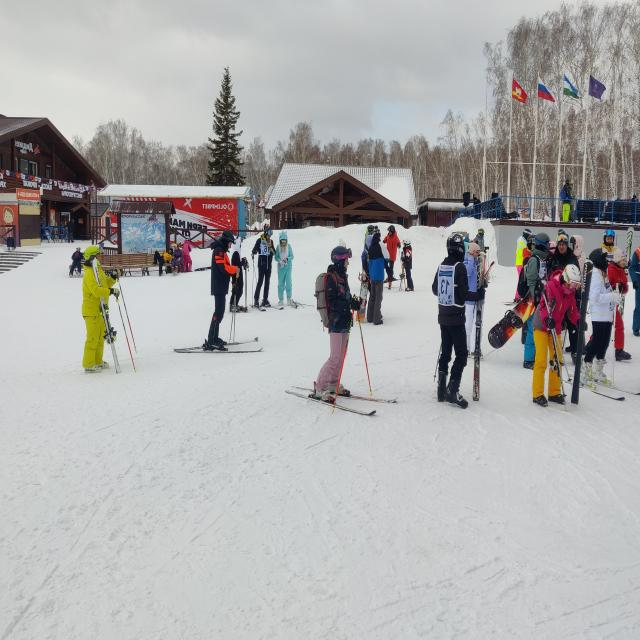

In [82]:
# !wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
image = cv2.imread("/content/Mountain-Skiers-3/train/IMG_20230305_105910_jpg.rf.b83208700bbc34273f8f426f69d4da36.jpg")
cv2_imshow(image)

In [83]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(image)

[03/06 19:14:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


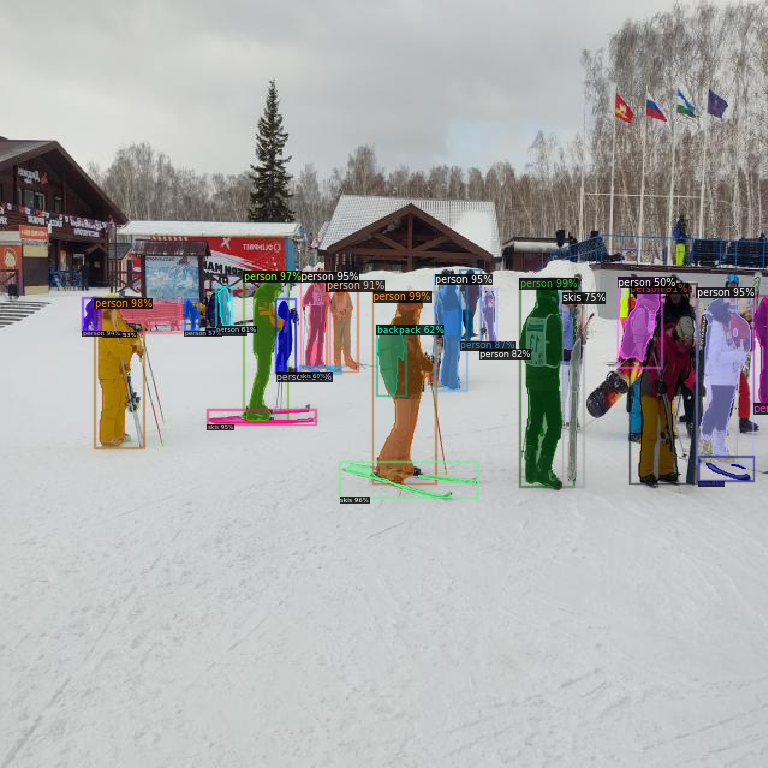

In [84]:
visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

## Train

In [85]:
DATA_SET_NAME = dataset.name.replace(" ", "-")
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

In [ ]:
# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME, 
    metadata={}, 
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH, 
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "test")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME, 
    metadata={}, 
    json_file=TEST_DATA_SET_ANN_FILE_PATH, 
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME, 
    metadata={}, 
    json_file=VALID_DATA_SET_ANN_FILE_PATH, 
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

WARNING [03/06 19:14:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/06 19:14:16 d2.data.datasets.coco]: Loaded 57 images in COCO format from /content/Mountain-Skiers-3/train/_annotations.coco.json


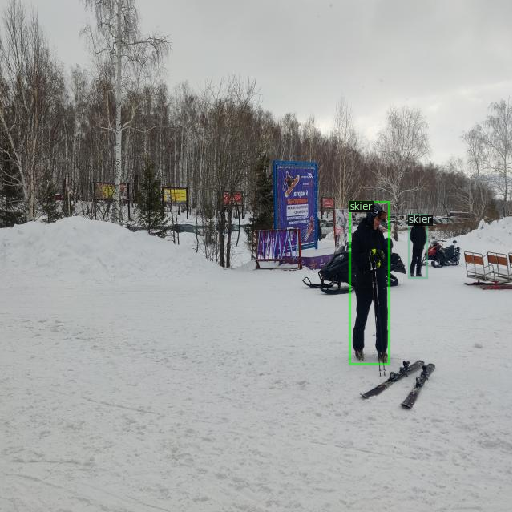

In [87]:
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[0]
image = cv2.imread(dataset_entry["file_name"])

visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata, 
    scale=0.8, 
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
cv2_imshow(out.get_image()[:, :, ::-1])

In [88]:
# HYPERPARAMETERS
ARCHITECTURE = "faster_rcnn_R_50_FPN_3x"
CONFIG_FILE_PATH = f"COCO-Detection/{ARCHITECTURE}.yaml"
MAX_ITER = 2000
EVAL_PERIOD = 200
BASE_LR = 0.001
NUM_CLASSES = 3

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME, 
    ARCHITECTURE, 
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [89]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

In [94]:
print('Number of parameters:', sum(p.numel() for p in trainer.model.parameters()))

Number of parameters: 41305311


In [70]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/06 17:55:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/06 17:55:49 d2.engine.train_loop]: Starting training from iteration 0
[03/06 17:55:55 d2.utils.events]:  eta: 0:09:04  iter: 19  total_loss: 1.777  loss_cls: 1.234  loss_box_reg: 0.409  loss_rpn_cls: 0.02711  loss_rpn_loc: 0.0329  time: 0.2813  last_time: 0.2393  data_time: 0.0232  last_data_time: 0.0057   lr: 1.9981e-05  max_mem: 2327M
[03/06 17:56:01 d2.utils.events]:  eta: 0:09:35  iter: 39  total_loss: 1.501  loss_cls: 0.9414  loss_box_reg: 0.4772  loss_rpn_cls: 0.03245  loss_rpn_loc: 0.0595  time: 0.2925  last_time: 0.3496  data_time: 0.0093  last_data_time: 0.0244   lr: 3.9961e-05  max_mem: 2327M
[03/06 17:56:07 d2.utils.events]:  eta: 0:09:23  iter: 59  total_loss: 1.175  loss_cls: 0.6255  loss_box_reg: 0.4667  loss_rpn_cls: 0.03575  loss_rpn_loc: 0.07622  time: 0.2911  last_time: 0.3184  data_time: 0.0105  last_data_time: 0.0058   lr: 5.9941e-05  max_mem: 2327M
[03/06 17:56:13 d2.utils.events]:  eta: 0:09:19  iter: 79  total_loss: 1.021  loss_cls: 0.4254  loss_box_reg: 0.43

In [71]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir $OUTPUT_DIR_PATH

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-03-06 18:06:15.958839: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-06 18:06:15.959545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-06 18:06:15.959576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are inst

## Evaluation

In [72]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
predictor = DefaultPredictor(cfg)

[03/06 18:08:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Mountain-Skiers/faster_rcnn_R_50_FPN_3x/2023-03-06-17-55-39/model_final.pth ...


WARNING [03/06 18:08:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/06 18:08:25 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/Mountain-Skiers-3/valid/_annotations.coco.json


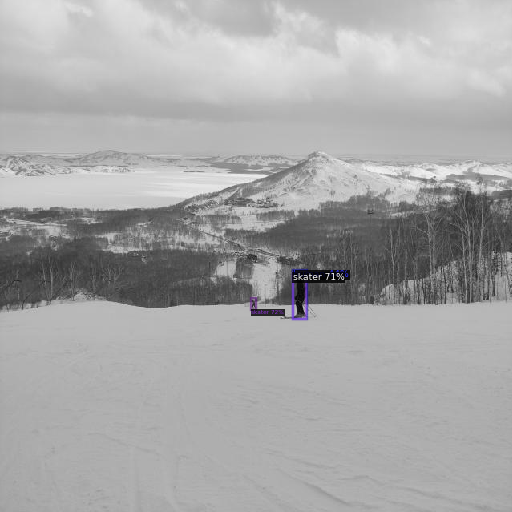

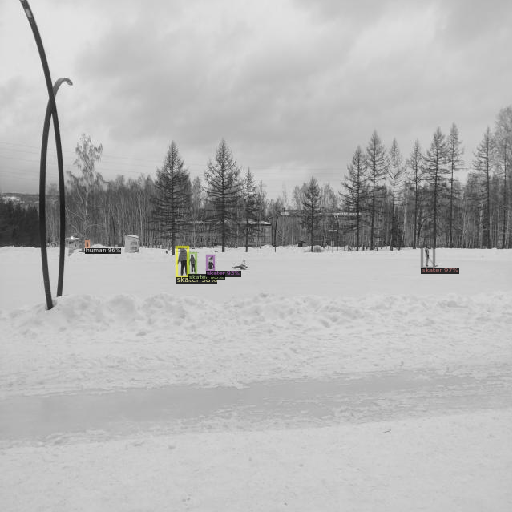

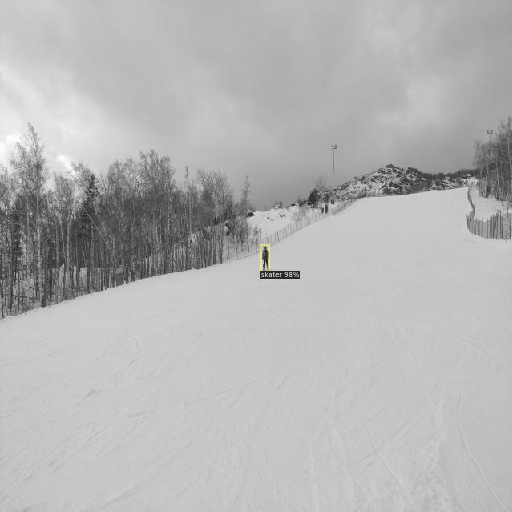

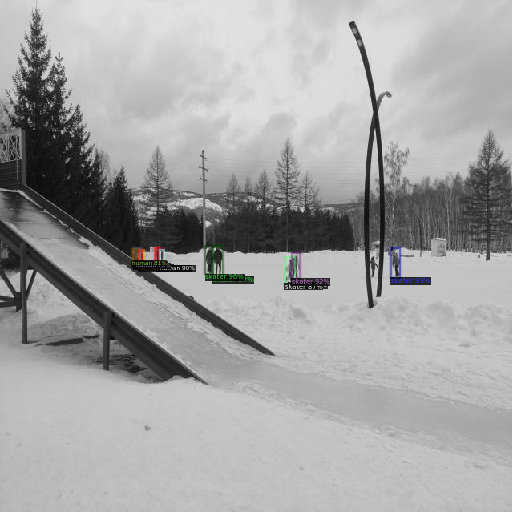

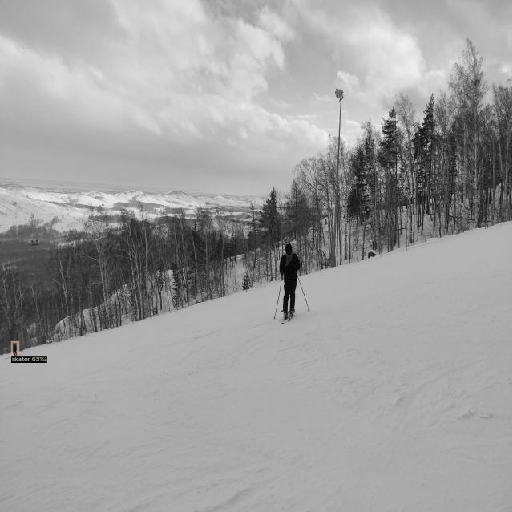

In [73]:
dataset_valid = DatasetCatalog.get(VALID_DATA_SET_NAME)

for d in dataset_valid:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    
    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata, 
        scale=0.8, 
        instance_mode=ColorMode.IMAGE_BW
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [77]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("Mountain-Skiers-test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "Mountain-Skiers-test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[03/06 18:14:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Mountain-Skiers/faster_rcnn_R_50_FPN_3x/2023-03-06-17-55-39/model_final.pth ...
WARNING [03/06 18:14:19 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [03/06 18:14:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/06 18:14:19 d2.data.datasets.coco]: Loaded 4 images in COCO format from /content/Mountain-Skiers-3/test/_annotations.coco.json
[03/06 18:14:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/06 18:14:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/06 18:14:19 d2.data.common]: Serializing 4 elements to byte tensors and concatenating them

OrderedDict([('bbox',
              {'AP': 12.35148514851485,
               'AP50': 26.45764576457646,
               'AP75': 10.643564356435643,
               'APs': 12.626119754832626,
               'APm': 20.0,
               'APl': 0.0,
               'AP-humans': nan,
               'AP-human': 0.0,
               'AP-skater': 37.054455445544555,
               'AP-skier': 0.0})])

# YOLO

## Installations

In [30]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install ultralytics==8.0.20

In [32]:
# Pip install method (recommended)

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [35]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI

In [41]:
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='/content/Mountain-Skiers-3/train/IMG_20230305_105910_jpg.rf.b83208700bbc34273f8f426f69d4da36.jpg' save=True

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
image 1/1 /content/Mountain-Skiers-3/train/IMG_20230305_105910_jpg.rf.b83208700bbc34273f8f426f69d4da36.jpg: 640x640 15 persons, 2 skiss, 9.5ms
Speed: 0.6ms pre-process, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict4


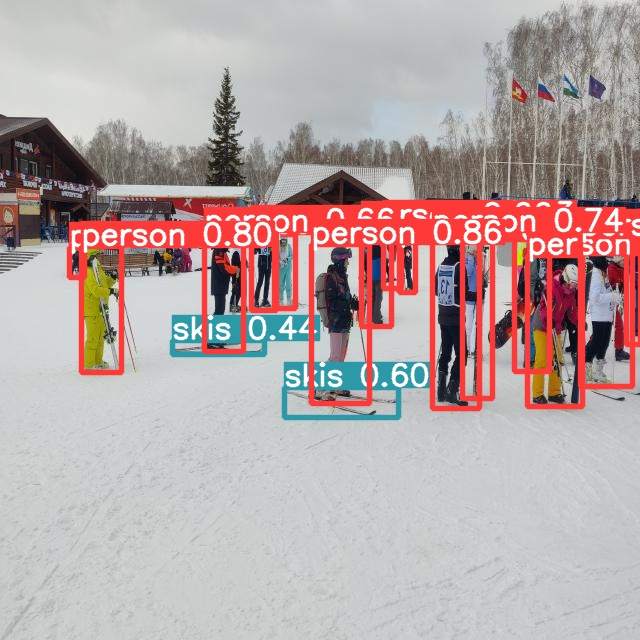

In [43]:
Image(filename='/content/runs/detect/predict4/IMG_20230305_105910_jpg.rf.b83208700bbc34273f8f426f69d4da36.jpg', height=600)

## Training

In [49]:
!mkdir ./datasets
%cd ./datasets

/content/datasets


In [50]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="SeScyFeiR90djceO280o")
project = rf.workspace("aml-92lrc").project("mountain-skiers")
dataset = project.version(3).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Mountain-Skiers-3 in yolov8:: 100%|██████████| 144/144 [00:00<00:00, 1781.88it/s]


In [51]:
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True

100% 21.5M/21.5M [00:00<00:00, 368MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/datasets/Mountain-Skiers-3/data.yaml, epochs=25, patience=50, batch=16, imgsz=800, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, o

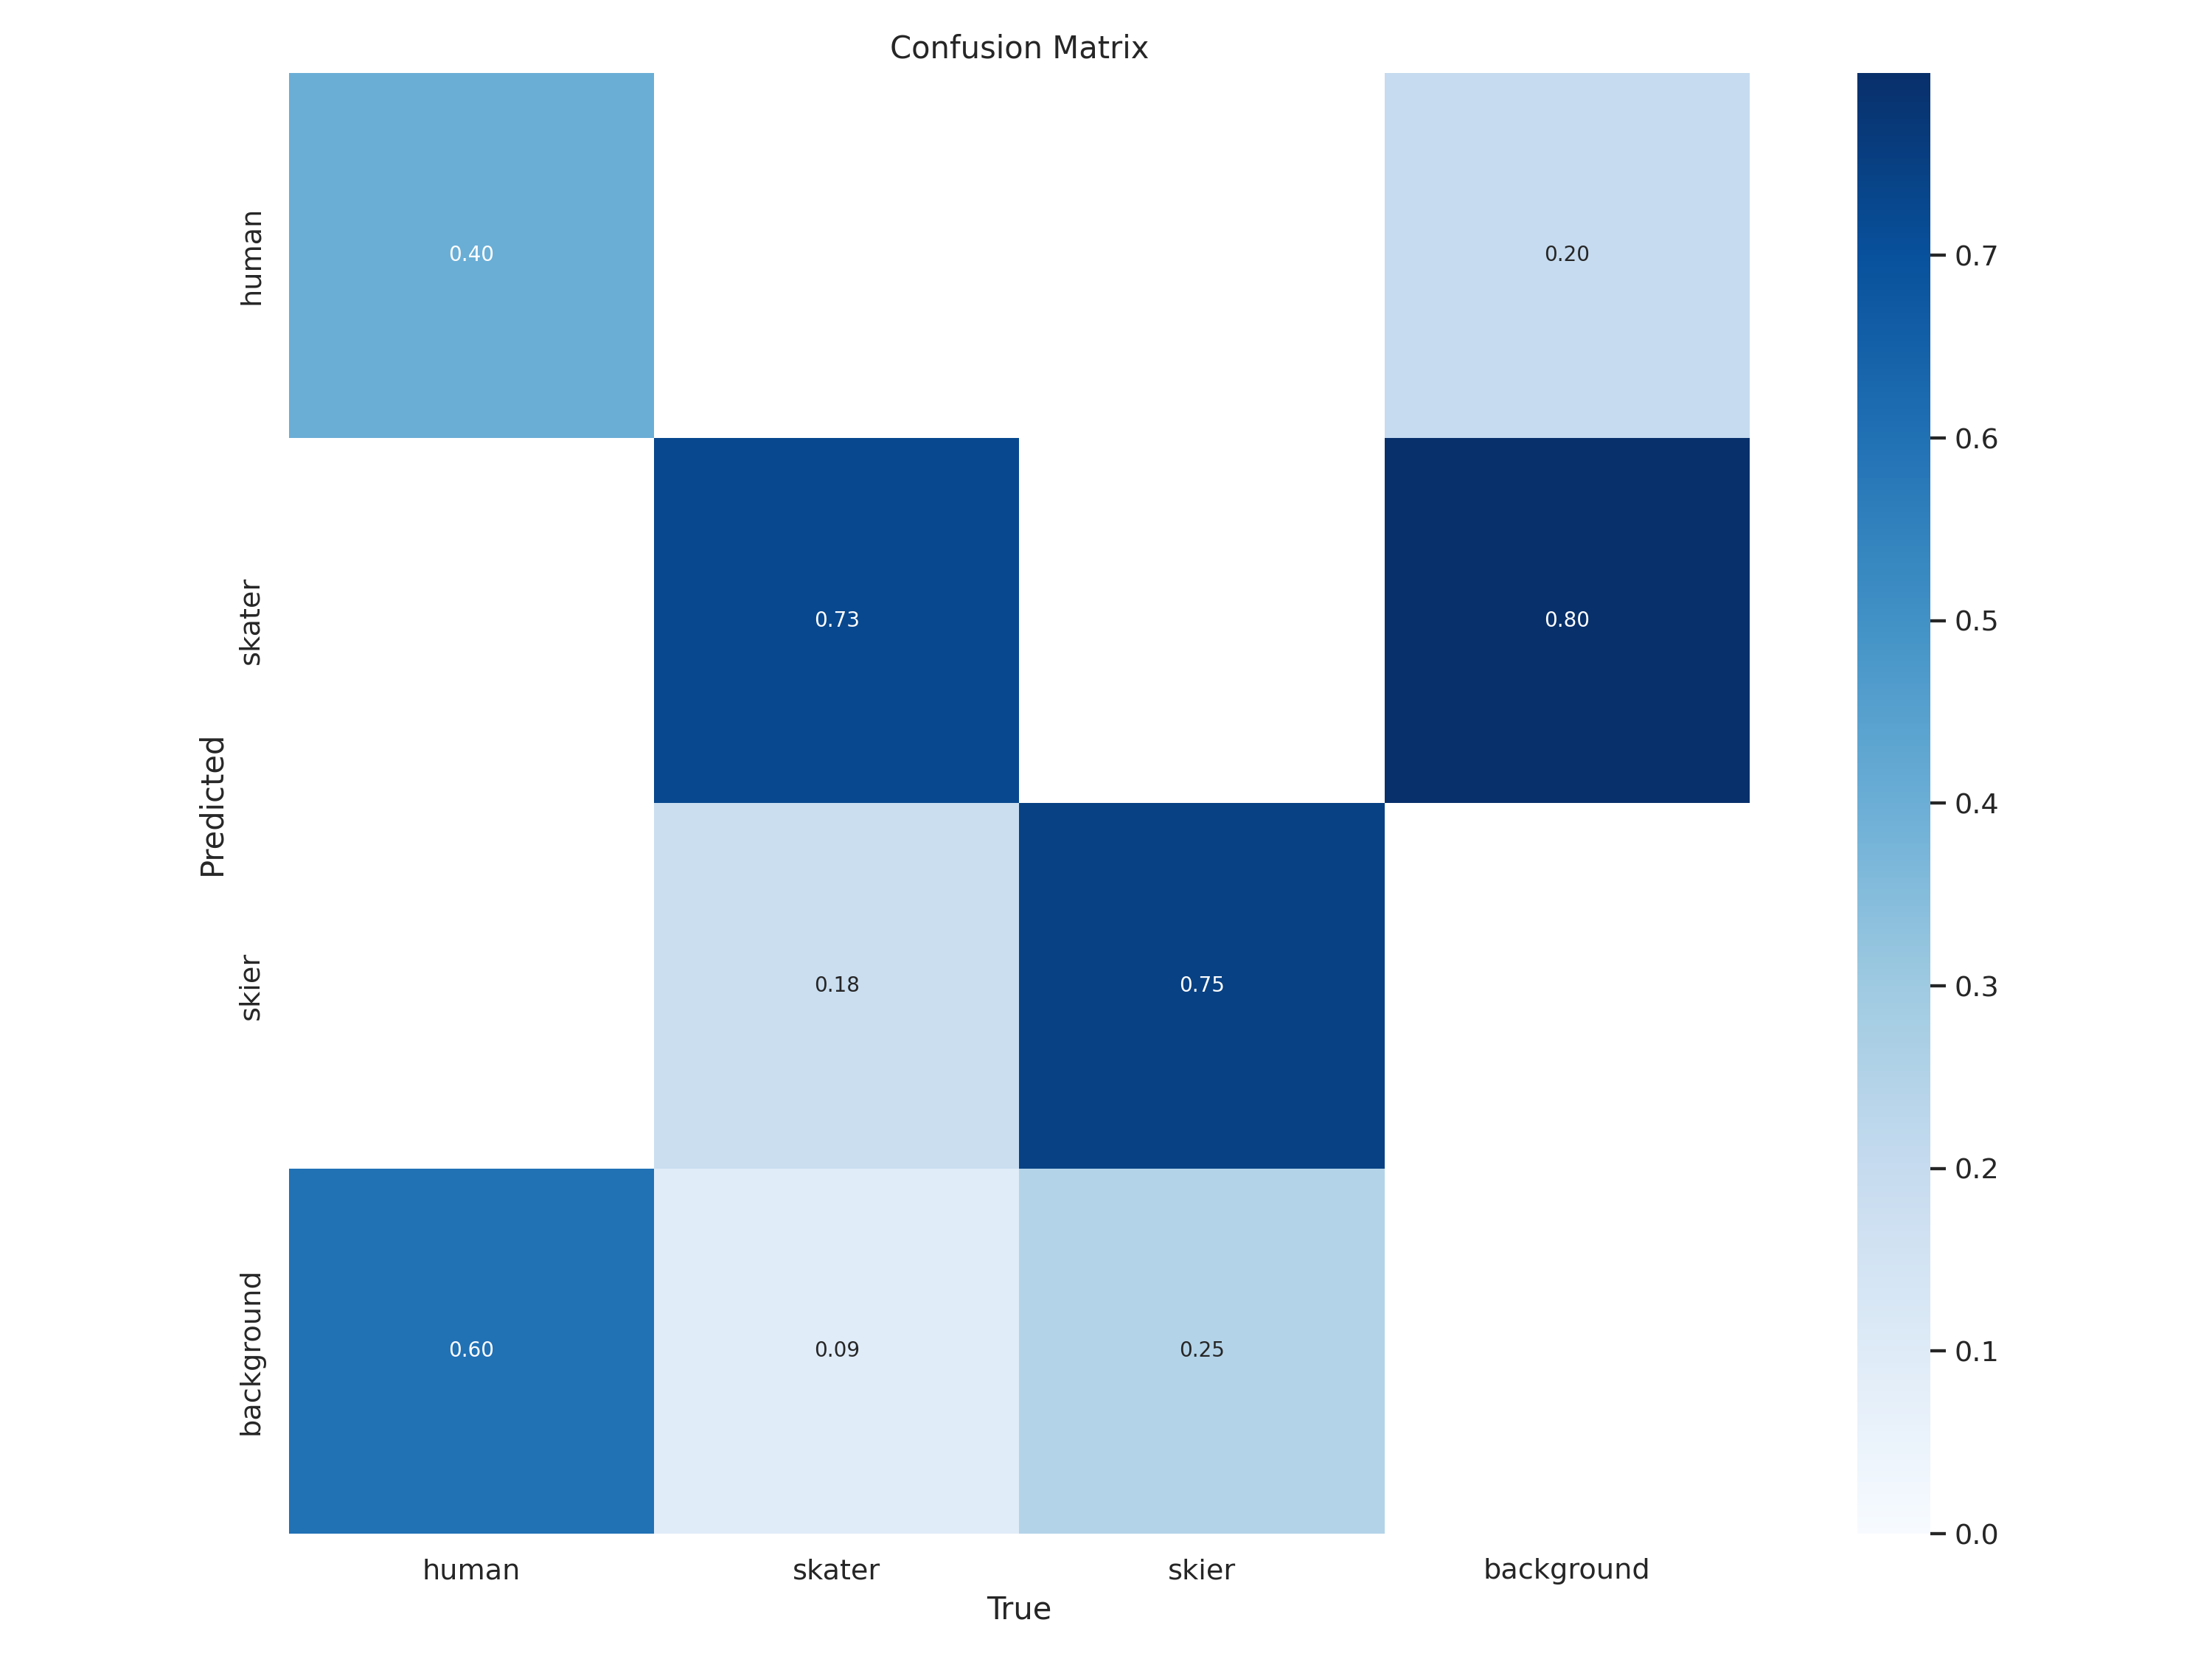

In [52]:
Image(filename=f'./runs/detect/train/confusion_matrix.png', width=600)

## Validation

In [57]:
!yolo task=detect mode=predict model=./runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
image 1/4 /content/datasets/Mountain-Skiers-3/test/images/IMG_20230304_184725_jpg.rf.0c9bf9f05f7ac43c5ad7008ff876241c.jpg: 800x800 8 skaters, 26.1ms
image 2/4 /content/datasets/Mountain-Skiers-3/test/images/IMG_20230305_105907_jpg.rf.b4ecf3b14c279ad5920d447e8d08f5b6.jpg: 800x800 1 skater, 14 skiers, 26.1ms
image 3/4 /content/datasets/Mountain-Skiers-3/test/images/IMG_20230305_105922_jpg.rf.299546d8ce51121ff9edaca33a442e15.jpg: 800x800 8 skiers, 26.1ms
image 4/4 /content/datasets/Mountain-Skiers-3/test/images/IMG_20230305_120343_jpg.rf.06493c3e8cef1cd4c8fbfbf98abd1e6e.jpg: 800x800 7 skiers, 26.1ms
Speed: 0.7ms pre-process, 26.1ms inference, 1.4ms postprocess per image at shape (1, 3, 800, 800)
Results saved to runs/detect/predict


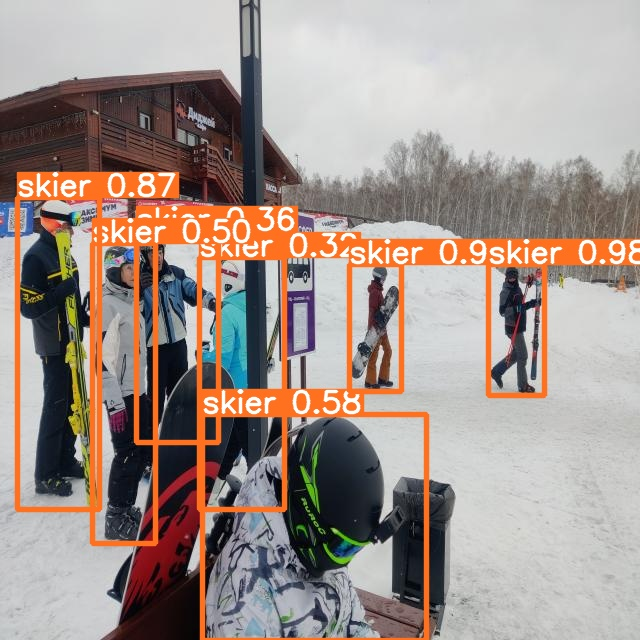

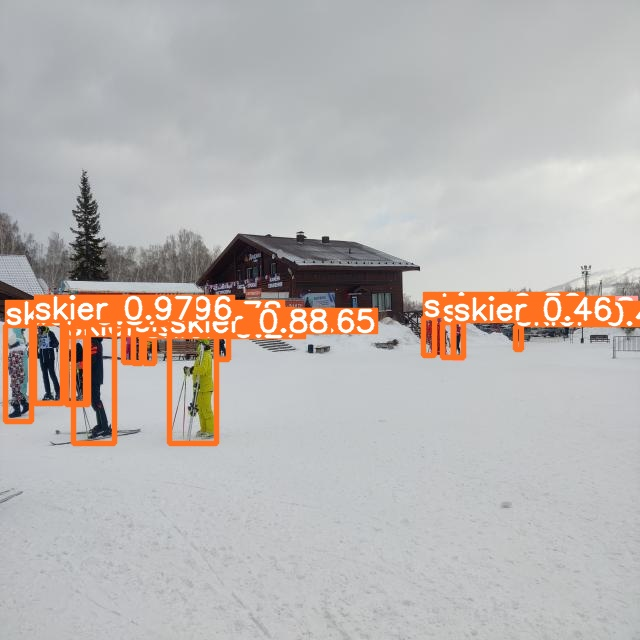

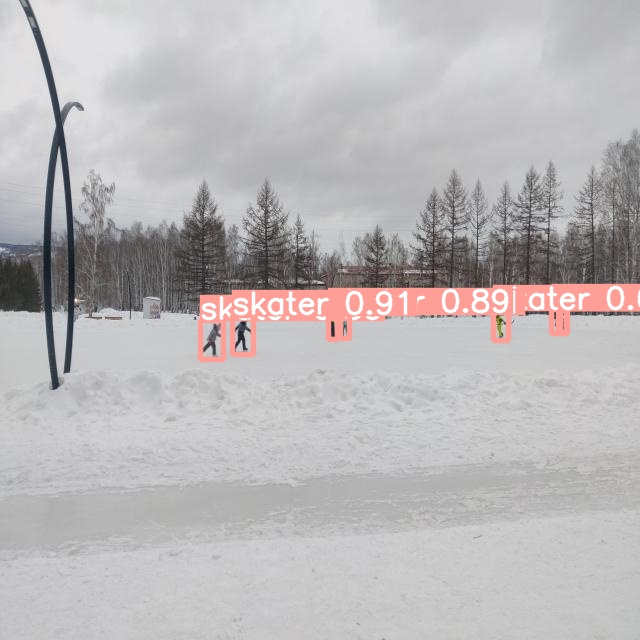

In [59]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'./runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [54]:
!yolo task=detect mode=val model=./runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/Mountain-Skiers-3/valid/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100% 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  2.19it/s]
                   all          5         20      0.878      0.612      0.667      0.293
                 human          5          5      0.802        0.2      0.432      0.136
                skater          5         11      0.832      0.909      0.798      0.556
                 skier          5          4          1      0.726       0.77      0.186
Speed: 0.4ms pre-process, 22.2ms inference, 0.0ms loss, 1.2ms post-process per image
